In [188]:
import time
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
import warnings
warnings.filterwarnings('ignore')

In [190]:
# Load data: Half-PPR ADP 2020
halfppr_adp_2020 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/half-ppr/2020/adp_data.csv')
halfppr_adp_2020.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
halfppr_adp_2020.head()

,ADPRank,Player,ADPPosRank,Yahoo,Fantrax,FFC,Sleeper,ADPAvg
0,1,Christian McCaffrey,RB1,1.0,1,1.0,NaN,1.0
1,2,Saquon Barkley,RB2,2.0,2,2.0,NaN,2.0
2,3,Ezekiel Elliott,RB3,3.0,3,3.0,NaN,3.0
3,4,Dalvin Cook,RB4,7.0,5,4.0,NaN,5.3
4,5,Alvin Kamara,RB5,4.0,6,6.0,NaN,5.3


In [192]:
# Load data: Half-PPR Weekly Points 2020
halfppr_weeklypoints_2020 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/half-ppr/2020/weekly_points_data.csv')
halfppr_weeklypoints_2020.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
halfppr_weeklypoints_2020.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
0,1,Josh Allen,QB,BUF,28.2,34.5,32.2,25.4,18.3,16.1,...,28.9,BYE,16.5,30.1,19.3,37.7,32.3,20.3,25.3,405.6
1,2,Kyler Murray,QB,ARI,27.3,33.1,24.7,23.1,27.3,28.9,...,30.9,20.3,8.9,17.4,18.5,34.1,16.4,3.8,24.4,390.7
2,3,Aaron Rodgers,QB,NYJ,30.8,18.7,24.5,29.6,-,5.8,...,26.4,22.7,25.6,23.5,30.9,18.3,26.1,26,24.2,387.8
3,4,Patrick Mahomes II,QB,KC,20.4,27.5,40,20.2,30.7,20.6,...,BYE,22.5,31.3,19.3,21.6,25.9,20.2,-,25.4,380.4
4,5,Deshaun Watson,QB,CLE,21.8,15.7,18.1,20.9,26.9,32,...,14.1,31.4,33.1,20.4,16.6,23.4,26.8,26.8,23.5,376.3


In [194]:
# Combine and Clean Data: Half-PPR 2020
halfppr_2020 = halfppr_adp_2020.merge(halfppr_weeklypoints_2020[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
halfppr_2020.set_index("Player", inplace = True)
halfppr_2020['ADPPosRank'] = halfppr_2020['ADPPosRank'].astype('category').cat.codes
halfppr_2020['Pos'] = halfppr_2020['Pos'].astype('category').cat.codes

halfppr_2020 = halfppr_2020.replace('-', 0)
halfppr_2020 = halfppr_2020.replace('BYE', 0)

halfppr_2020["Yahoo"].fillna(0, inplace = True)
halfppr_2020["Fantrax"].fillna(0, inplace = True)
halfppr_2020["FFC"].fillna(0, inplace = True)
halfppr_2020["Sleeper"].fillna(0, inplace = True)

halfppr_2020.head()

,ADPRank,ADPPosRank,Yahoo,Fantrax,FFC,Sleeper,ADPAvg,PointRank,Pos,1,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1,75,1.0,1,1.0,0.0,1.0,236,2,27,...,0,0,0,0,0,0,0,0,27.3,81.9
Saquon Barkley,2,91,2.0,2,2.0,0.0,2.0,493,2,9.6,...,0,0,0,0,0,0,0,0,6.2,12.4
Ezekiel Elliott,3,102,3.0,3,3.0,0.0,3.0,48,2,26.2,...,0,18.4,2.4,11.5,6.9,0,15.9,13.6,13.2,197.7
Dalvin Cook,4,113,7.0,5,4.0,0.0,5.3,14,2,21.3,...,13.2,22.5,8.2,20.9,18,24.4,15.5,0,22.6,315.8
Alvin Kamara,5,124,4.0,6,6.0,0.0,5.3,11,2,21.2,...,31.3,10.5,5.7,16.7,18.9,16.9,54.7,0,22.4,336.3


In [196]:
# Set X, y
X = halfppr_2020[['ADPRank', 'ADPPosRank', 'Yahoo', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = halfppr_2020['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [198]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_halfppr_2020 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_halfppr_2020 = SequentialFeatureSelector(logreg_halfppr_2020, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_halfppr_2020.fit(X_train, y_train)

sel_features_halfppr_2020 = X_train.columns[seq_features_halfppr_2020.get_support()]

print("Most Important Features Half-PPR 2020:", sel_features_halfppr_2020)

# Fit the model and measure time
start_time = time.time()
logreg_halfppr_2020.fit(X_train, y_train)
logreg_halfppr_2020_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_halfppr_2020.predict(X_train)
y_test_pred = logreg_halfppr_2020.predict(X_test)

# Calculate train and test scores
logreg_halfppr_2020_train_score = mean_squared_error(y_train, y_train_pred)
logreg_halfppr_2020_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Half-PPR 2020 Train Score:", logreg_halfppr_2020_train_score)
print("Logistic Regression Half-PPR 2020 Test Score:", logreg_halfppr_2020_test_score)
print("Logistic Regression Half-PPR 2020 Fit Time:", logreg_halfppr_2020_fit_time)

Most Important Features Half-PPR 2020: Index(['ADPRank', 'FFC'], dtype='object')
Logistic Regression Half-PPR 2020 Train Score: 15461.264367816091
Logistic Regression Half-PPR 2020 Test Score: 43197.27272727273
Logistic Regression Half-PPR 2020 Fit Time: 0.12772107124328613


In [206]:
# Load data: Half-PPR ADP 2021
halfppr_adp_2021 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/half-ppr/2021/adp_data.csv')
halfppr_adp_2021.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
halfppr_adp_2021.head()

,ADPRank,Player,ADPPosRank,Yahoo,Fantrax,FFC,Sleeper,ADPAvg
0,1,Christian McCaffrey,RB1,1.0,1.0,1.0,1.0,1.0
1,2,Dalvin Cook,RB2,2.0,2.0,2.0,2.0,2.0
2,3,Derrick Henry,RB3,3.0,3.0,4.0,3.0,3.3
3,4,Alvin Kamara,RB4,4.0,4.0,3.0,4.0,3.8
4,5,Ezekiel Elliott,RB5,5.0,5.0,5.0,5.0,5.0


In [208]:
# Load data: Half-PPR Weekly Points 2021
halfppr_weeklypoints_2021 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/half-ppr/2021/weekly_points_data.csv')
halfppr_weeklypoints_2021.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
halfppr_weeklypoints_2021.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,PointAvg,PointTotal
0,1,Josh Allen,QB,BUF,17.2,17.7,37.2,21,36.5,29.7,...,18.2,28.7,11.7,36.2,21.8,31,23.9,23.9,24.6,417.6
1,2,Justin Herbert,QB,LAC,14.4,16.7,30.8,21.3,42.8,12,...,35.3,21.7,26.3,24.9,24,18.9,17.7,28.4,23.3,395.8
2,3,Tom Brady,QB,FA,29.2,29.6,28.7,11.1,37.7,19,...,20.3,12.2,29.6,30.1,5.8,14.4,27.4,25,22.7,386.7
3,4,Patrick Mahomes II,QB,KC,33.3,25,24.9,32.3,21,25,...,8.5,BYE,13.6,20.3,30.6,22.3,20.9,26.2,22.0,374.2
4,5,Cooper Kupp,WR,LAR,20.3,32.3,26.1,8.9,12.7,29.5,...,BYE,15.1,22.9,24.8,30.2,16.3,18.5,23.1,21.6,367.0


In [210]:
# Combine and Clean Data: Half-PPR 2021
halfppr_2021 = halfppr_adp_2021.merge(halfppr_weeklypoints_2021[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
halfppr_2021.set_index("Player", inplace = True)
halfppr_2021['ADPPosRank'] = halfppr_2021['ADPPosRank'].astype('category').cat.codes
halfppr_2021['Pos'] = halfppr_2021['Pos'].astype('category').cat.codes

halfppr_2021 = halfppr_2021.replace('-', 0)
halfppr_2021 = halfppr_2021.replace('BYE', 0)

halfppr_2021["Yahoo"].fillna(0, inplace = True)
halfppr_2021["Fantrax"].fillna(0, inplace = True)
halfppr_2021["FFC"].fillna(0, inplace = True)
halfppr_2021["Sleeper"].fillna(0, inplace = True)

halfppr_2021.head()

,ADPRank,ADPPosRank,Yahoo,Fantrax,FFC,Sleeper,ADPAvg,PointRank,Pos,1,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1,85,1.0,1.0,1.0,1.0,1.0,178,2,23.2,...,21.1,21.4,3.5,0,0,0,0,0,15.6,109.0
Dalvin Cook,2,123,2.0,2.0,2.0,2.0,2.0,62,2,17.4,...,19.3,21,11.3,0,34.7,10.1,0,2.8,14.6,189.3
Derrick Henry,3,133,3.0,3.0,4.0,3.0,3.3,65,2,9.2,...,0,0,0,0,0,0,0,0,23.0,184.3
Alvin Kamara,4,144,4.0,4.0,3.0,4.0,3.8,41,2,16.6,...,0,0,0,0,22.5,4.1,6.9,18.5,16.2,211.2
Ezekiel Elliott,5,155,5.0,5.0,5.0,5.0,5.0,34,2,4.9,...,19.3,9.8,13.9,5.7,8.5,14.7,16.7,3.5,13.4,228.6


In [212]:
# Set X, y
X = halfppr_2021[['ADPRank', 'ADPPosRank', 'Yahoo', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = halfppr_2021['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [214]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_halfppr_2021 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_halfppr_2021 = SequentialFeatureSelector(logreg_halfppr_2021, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_halfppr_2021.fit(X_train, y_train)

sel_features_halfppr_2021 = X_train.columns[seq_features_halfppr_2021.get_support()]

print("Most Important Features Half-PPR 2021:", sel_features_halfppr_2021)

# Fit the model and measure time
start_time = time.time()
logreg_halfppr_2021.fit(X_train, y_train)
logreg_halfppr_2021_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_halfppr_2021.predict(X_train)
y_test_pred = logreg_halfppr_2021.predict(X_test)

# Calculate train and test scores
logreg_halfppr_2021_train_score = mean_squared_error(y_train, y_train_pred)
logreg_halfppr_2021_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Half-PPR 2021 Train Score:", logreg_halfppr_2021_train_score)
print("Logistic Regression Half-PPR 2021 Test Score:", logreg_halfppr_2021_test_score)
print("Logistic Regression Half-PPR 2021 Fit Time:", logreg_halfppr_2021_fit_time)

Most Important Features Half-PPR 2021: Index(['Yahoo', 'Pos'], dtype='object')
Logistic Regression Half-PPR 2021 Train Score: 29207.86798679868
Logistic Regression Half-PPR 2021 Test Score: 38772.60396039604
Logistic Regression Half-PPR 2021 Fit Time: 0.15991806983947754


In [220]:
# Load data: Half-PPR ADP 2022
halfppr_adp_2022 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/half-ppr/2022/adp_data.csv')
halfppr_adp_2022.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
halfppr_adp_2022.head()

,ADPRank,Player,ADPPosRank,Yahoo,Fantrax,FFC,Sleeper,ADPAvg
0,1,Jonathan Taylor,RB1,1.0,NaN,NaN,1.0,1.0
1,2,Christian McCaffrey,RB2,2.0,NaN,NaN,2.0,2.0
2,3,Austin Ekeler,RB3,3.0,NaN,NaN,4.0,3.5
3,4,Derrick Henry,RB4,6.0,NaN,NaN,3.0,4.5
4,5,Cooper Kupp,WR1,4.0,NaN,NaN,5.0,4.5


In [222]:
# Load data: Half-PPR Weekly Points 2022
halfppr_weeklypoints_2022 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/half-ppr/2022/weekly_points_data.csv')
halfppr_weeklypoints_2022.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
halfppr_weeklypoints_2022.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,PointAvg,PointTotal
0,1,Patrick Mahomes II,QB,KC,34.9,17.3,18.1,24.4,30.5,21.6,...,27.5,19.4,19.8,22.8,32.7,23.8,26,15,25.2,428.9
1,2,Josh Allen,QB,BUF,33.5,29.7,26.7,24.5,36.2,26.4,...,12.6,30.9,16.9,20.6,35.9,25,2.7,22.8,24.2,412.2
2,3,Jalen Hurts,QB,PHI,24.7,34,27.6,17,27.7,16.9,...,24.2,29.8,34.4,30.4,36.7,-,-,9.5,25.6,384.0
3,4,Joe Burrow,QB,CIN,22.2,16.6,23,20.1,18.3,32.5,...,28.7,18,30,17.6,25.8,25.5,6.3,11.6,21.7,369.0
4,5,Austin Ekeler,RB,LAC,9.2,13.9,9.3,31.9,33.9,19.3,...,17,19.5,10.7,20.4,14,21.9,30.1,7,18.8,319.2


In [224]:
# Combine and Clean Data: Half-PPR 2022
halfppr_2022 = halfppr_adp_2022.merge(halfppr_weeklypoints_2022[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
halfppr_2022.set_index("Player", inplace = True)
halfppr_2022['ADPPosRank'] = halfppr_2022['ADPPosRank'].astype('category').cat.codes
halfppr_2022['Pos'] = halfppr_2022['Pos'].astype('category').cat.codes

halfppr_2022 = halfppr_2022.replace('-', 0)
halfppr_2022 = halfppr_2022.replace('BYE', 0)

halfppr_2022["Yahoo"].fillna(0, inplace = True)
halfppr_2022["Fantrax"].fillna(0, inplace = True)
halfppr_2022["FFC"].fillna(0, inplace = True)
halfppr_2022["Sleeper"].fillna(0, inplace = True)

halfppr_2022.head()

,ADPRank,ADPPosRank,Yahoo,Fantrax,FFC,Sleeper,ADPAvg,PointRank,Pos,1,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Jonathan Taylor,1,52,1.0,0.0,0.0,1.0,1.0,134,2,25.5,...,23.3,14.9,17.3,11.8,0,1.8,0,0,11.0,132.4
Christian McCaffrey,2,63,2.0,0.0,0.0,2.0,2.0,7,2,13.7,...,15.7,14.1,6.9,24.6,28.3,22.8,12.8,28.3,18.5,313.9
Austin Ekeler,3,74,3.0,0.0,0.0,4.0,3.5,5,2,9.2,...,9.8,17,19.5,10.7,20.4,14,21.9,30.1,18.8,319.2
Derrick Henry,4,85,6.0,0.0,0.0,3.0,4.5,16,2,8.2,...,7.7,24.4,13.2,4.8,19,24.3,17.6,0,17.9,286.3
Cooper Kupp,5,156,4.0,0.0,0.0,5.0,4.5,79,4,25.3,...,1.4,0,0,0,0,0,0,0,18.2,163.9


In [226]:
# Set X, y
X = halfppr_2022[['ADPRank', 'ADPPosRank', 'Yahoo', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = halfppr_2022['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [228]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_halfppr_2022 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_halfppr_2022 = SequentialFeatureSelector(logreg_halfppr_2022, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_halfppr_2022.fit(X_train, y_train)

sel_features_halfppr_2022 = X_train.columns[seq_features_halfppr_2022.get_support()]

print("Most Important Features Half-PPR 2022:", sel_features_halfppr_2022)

# Fit the model and measure time
start_time = time.time()
logreg_halfppr_2022.fit(X_train, y_train)
logreg_halfppr_2022_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_halfppr_2022.predict(X_train)
y_test_pred = logreg_halfppr_2022.predict(X_test)

# Calculate train and test scores
logreg_halfppr_2022_train_score = mean_squared_error(y_train, y_train_pred)
logreg_halfppr_2022_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Half-PPR 2022 Train Score:", logreg_halfppr_2022_train_score)
print("Logistic Regression Half-PPR 2022 Test Score:", logreg_halfppr_2022_test_score)
print("Logistic Regression Half-PPR 2022 Fit Time:", logreg_halfppr_2022_fit_time)

Most Important Features Half-PPR 2022: Index(['Yahoo', 'Pos'], dtype='object')
Logistic Regression Half-PPR 2022 Train Score: 14810.79781420765
Logistic Regression Half-PPR 2022 Test Score: 32455.09836065574
Logistic Regression Half-PPR 2022 Fit Time: 0.03780698776245117


In [238]:
# Load data: Full-PPR ADP 2020
ppr_adp_2020 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/ppr/2020/adp_data.csv')
ppr_adp_2020.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
ppr_adp_2020.head()

,ADPRank,Player,ADPPosRank,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,ADPAvg
0,1,Christian McCaffrey,RB1,1.0,1.0,NaN,1.0,1.0,NaN,1.0
1,2,Saquon Barkley,RB2,2.0,2.0,NaN,2.0,2.0,NaN,2.0
2,3,Ezekiel Elliott,RB3,3.0,3.0,NaN,3.0,3.0,NaN,3.0
3,4,Dalvin Cook,RB4,4.0,4.0,NaN,6.0,5.0,NaN,4.8
4,5,Michael Thomas,WR1,6.0,6.0,NaN,4.0,4.0,NaN,5.0


In [248]:
# Load data: Full-PPR Weekly Points 2020
ppr_weeklypoints_2020 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/ppr/2020/weekly_points_data.csv')
ppr_weeklypoints_2020.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
ppr_weeklypoints_2020.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
0,1,Josh Allen,QB,BUF,28.2,34.5,32.2,25.4,18.3,16.1,...,29.4,BYE,16.5,30.1,19.3,37.7,32.3,20.3,25.4,406.1
1,2,Kyler Murray,QB,ARI,27.3,33.1,24.7,23.1,27.3,28.9,...,30.9,20.3,8.9,17.4,18.5,34.1,16.4,3.8,24.4,390.7
2,3,Aaron Rodgers,QB,NYJ,30.8,19.2,24.5,29.6,-,5.8,...,26.4,22.7,25.6,23.5,30.9,18.3,26.1,26,24.3,388.3
3,4,Patrick Mahomes II,QB,KC,20.4,27.5,40,20.2,30.7,20.6,...,BYE,22.5,31.3,19.3,21.6,25.9,20.2,-,25.4,380.4
4,5,Alvin Kamara,RB,NO,23.7,38.4,44.7,20.9,19.9,BYE,...,34.8,10.5,6.2,17.7,22.4,18.4,56.2,-,25.2,377.8


In [250]:
# Combine and Clean Data: Full-PPR 2020
ppr_2020 = ppr_adp_2020.merge(ppr_weeklypoints_2020[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
ppr_2020.set_index("Player", inplace = True)
ppr_2020['ADPPosRank'] = ppr_2020['ADPPosRank'].astype('category').cat.codes
ppr_2020['Pos'] = ppr_2020['Pos'].astype('category').cat.codes

ppr_2020 = ppr_2020.replace('-', 0)
ppr_2020 = ppr_2020.replace('BYE', 0)

ppr_2020["ESPN"].fillna(0, inplace = True)
ppr_2020["RTSports"].fillna(0, inplace = True)
ppr_2020["MFL"].fillna(0, inplace = True)
ppr_2020["Fantrax"].fillna(0, inplace = True)
ppr_2020["FFC"].fillna(0, inplace = True)
ppr_2020["Sleeper"].fillna(0, inplace = True)

ppr_2020.head()

,ADPRank,ADPPosRank,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,ADPAvg,PointRank,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1,100,1.0,1.0,0.0,1.0,1.0,0.0,1.0,245,...,0,0,0,0,0,0,0,0,30.1,90.4
Saquon Barkley,2,148,2.0,2.0,0.0,2.0,2.0,0.0,2.0,487,...,0,0,0,0,0,0,0,0,7.7,15.4
Ezekiel Elliott,3,159,3.0,3.0,0.0,3.0,3.0,0.0,3.0,51,...,0,19.4,2.9,13.5,7.9,0,17.9,15.1,14.9,223.7
Dalvin Cook,4,170,4.0,4.0,0.0,6.0,5.0,0.0,4.8,13,...,15.2,25,10.2,23.9,19,26.9,16.5,0,24.1,337.8
Michael Thomas,5,311,6.0,6.0,0.0,4.0,4.0,0.0,5.0,261,...,4.7,19.4,9.1,19.5,16.4,0,0,0,12.0,83.9


In [254]:
# Set X, y
X = ppr_2020[['ADPRank', 'ADPPosRank', 'ESPN', 'RTSports', 'MFL', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = ppr_2020['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [256]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_ppr_2020 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_ppr_2020 = SequentialFeatureSelector(logreg_ppr_2020, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_ppr_2020.fit(X_train, y_train)

sel_features_ppr_2020 = X_train.columns[seq_features_ppr_2020.get_support()]

print("Most Important Features Full-PPR 2020:", sel_features_ppr_2020)

# Fit the model and measure time
start_time = time.time()
logreg_ppr_2020.fit(X_train, y_train)
logreg_ppr_2020_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_ppr_2020.predict(X_train)
y_test_pred = logreg_ppr_2020.predict(X_test)

# Calculate train and test scores
logreg_ppr_2020_train_score = mean_squared_error(y_train, y_train_pred)
logreg_ppr_2020_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Full-PPR 2020 Train Score:", logreg_ppr_2020_train_score)
print("Logistic Regression Full-PPR 2020 Test Score:", logreg_ppr_2020_test_score)
print("Logistic Regression Full-PPR 2020 Fit Time:", logreg_ppr_2020_fit_time)

Most Important Features Full-PPR 2020: Index(['ADPPosRank', 'RTSports'], dtype='object')
Logistic Regression Full-PPR 2020 Train Score: 20961.352435530087
Logistic Regression Full-PPR 2020 Test Score: 36439.042735042734
Logistic Regression Full-PPR 2020 Fit Time: 0.32544517517089844


In [260]:
# Load data: Full-PPR ADP 2021
ppr_adp_2021 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/ppr/2021/adp_data.csv')
ppr_adp_2021.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
ppr_adp_2021.head()

,ADPRank,Player,ADPPosRank,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,ADPAvg
0,1,Christian McCaffrey,RB1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,Dalvin Cook,RB2,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,3,Alvin Kamara,RB3,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,4,Derrick Henry,RB4,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,5,Ezekiel Elliott,RB5,8.0,5.0,6.0,5.0,5.0,5.0,5.8


In [262]:
# Load data: Full-PPR Weekly Points 2021
ppr_weeklypoints_2021 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/ppr/2021/weekly_points_data.csv')
ppr_weeklypoints_2021.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
ppr_weeklypoints_2021.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,PointAvg,PointTotal
0,1,Cooper Kupp,WR,LAR,23.8,36.8,30.6,11.4,16.2,34,...,BYE,18.6,26.9,31.3,34.7,21.3,21.5,26.6,25.9,439.5
1,2,Josh Allen,QB,BUF,17.2,17.7,37.2,21,36.5,29.7,...,18.2,28.7,11.7,36.2,21.8,31,23.9,23.9,24.6,417.6
2,3,Justin Herbert,QB,LAC,14.4,16.7,30.8,21.3,42.8,12,...,35.3,21.7,26.3,24.9,24,18.9,17.7,28.4,23.3,395.8
3,4,Tom Brady,QB,FA,29.2,29.6,28.7,11.1,37.7,19,...,20.3,12.2,29.6,30.1,5.8,14.4,27.4,25,22.7,386.7
4,5,Patrick Mahomes II,QB,KC,33.3,25,24.9,32.3,21,25,...,8.5,BYE,13.6,20.3,30.6,22.3,20.9,26.2,22.0,374.2


In [264]:
# Combine and Clean Data: Full-PPR 2020
ppr_2021 = ppr_adp_2021.merge(ppr_weeklypoints_2021[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
ppr_2021.set_index("Player", inplace = True)
ppr_2021['ADPPosRank'] = ppr_2021['ADPPosRank'].astype('category').cat.codes
ppr_2021['Pos'] = ppr_2021['Pos'].astype('category').cat.codes

ppr_2021 = ppr_2021.replace('-', 0)
ppr_2021 = ppr_2021.replace('BYE', 0)

ppr_2021["ESPN"].fillna(0, inplace = True)
ppr_2021["RTSports"].fillna(0, inplace = True)
ppr_2021["MFL"].fillna(0, inplace = True)
ppr_2021["Fantrax"].fillna(0, inplace = True)
ppr_2021["FFC"].fillna(0, inplace = True)
ppr_2021["Sleeper"].fillna(0, inplace = True)

ppr_2021.head()

,ADPRank,ADPPosRank,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,ADPAvg,PointRank,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1,86,1.0,1.0,1.0,1.0,1.0,1.0,1.0,168,...,26.1,24.9,3.5,0,0,0,0,0,18.2,127.5
Dalvin Cook,2,122,2.0,2.0,2.0,2.0,2.0,2.0,2.0,68,...,20.8,22.5,14.3,0,35.2,11.1,0,4.3,15.9,206.3
Alvin Kamara,3,132,3.0,3.0,3.0,3.0,3.0,3.0,3.0,48,...,0,0,0,0,24.5,5.1,7.9,21,18.1,234.7
Derrick Henry,4,143,4.0,4.0,4.0,4.0,4.0,4.0,4.0,79,...,0,0,0,0,0,0,0,0,24.2,193.3
Ezekiel Elliott,5,154,8.0,5.0,6.0,5.0,5.0,5.0,5.8,35,...,20.8,12.8,16.9,6.7,9,16.2,17.2,4,14.8,252.1


In [266]:
# Set X, y
X = ppr_2021[['ADPRank', 'ADPPosRank', 'ESPN', 'RTSports', 'MFL', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = ppr_2021['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [268]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_ppr_2021 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_ppr_2021 = SequentialFeatureSelector(logreg_ppr_2021, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_ppr_2021.fit(X_train, y_train)

sel_features_ppr_2021 = X_train.columns[seq_features_ppr_2021.get_support()]

print("Most Important Features Full-PPR 2021:", sel_features_ppr_2021)

# Fit the model and measure time
start_time = time.time()
logreg_ppr_2021.fit(X_train, y_train)
logreg_ppr_2021_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_ppr_2021.predict(X_train)
y_test_pred = logreg_ppr_2021.predict(X_test)

# Calculate train and test scores
logreg_ppr_2021_train_score = mean_squared_error(y_train, y_train_pred)
logreg_ppr_2021_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Full-PPR 2021 Train Score:", logreg_ppr_2021_train_score)
print("Logistic Regression Full-PPR 2021 Test Score:", logreg_ppr_2021_test_score)
print("Logistic Regression Full-PPR 2021 Fit Time:", logreg_ppr_2021_fit_time)

Most Important Features Full-PPR 2021: Index(['RTSports', 'Pos'], dtype='object')
Logistic Regression Full-PPR 2021 Train Score: 18273.539735099337
Logistic Regression Full-PPR 2021 Test Score: 33084.653465346535
Logistic Regression Full-PPR 2021 Fit Time: 0.2096090316772461


In [270]:
# Load data: Full-PPR ADP 2022
ppr_adp_2022 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/ppr/2022/adp_data.csv')
ppr_adp_2022.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
ppr_adp_2022.head()

,ADPRank,Player,ADPPosRank,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,ADPAvg
0,1,Jonathan Taylor,RB1,1.0,1.0,NaN,NaN,NaN,1.0,1.0
1,2,Christian McCaffrey,RB2,2.0,2.0,NaN,NaN,NaN,2.0,2.0
2,3,Austin Ekeler,RB3,4.0,3.0,NaN,NaN,NaN,4.0,3.8
3,4,Cooper Kupp,WR1,3.0,5.0,NaN,NaN,NaN,5.0,4.0
4,5,Derrick Henry,RB4,5.0,8.0,NaN,NaN,NaN,3.0,5.3


In [272]:
# Load data: Full-PPR Weekly Points 2022
ppr_weeklypoints_2022 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/ppr/2022/weekly_points_data.csv')
ppr_weeklypoints_2022.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
ppr_weeklypoints_2022.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,PointAvg,PointTotal
0,1,Patrick Mahomes II,QB,KC,34.9,17.3,18.1,24.4,30.5,21.6,...,27.5,19.4,19.8,22.8,32.7,23.8,26.5,15,25.3,429.4
1,2,Josh Allen,QB,BUF,33.5,29.7,26.7,24.5,36.2,26.4,...,12.6,30.9,16.9,20.6,35.9,25,2.7,22.8,24.2,412.2
2,3,Jalen Hurts,QB,PHI,24.7,34,27.6,17,27.7,16.9,...,24.2,29.8,34.4,30.4,36.7,-,-,9.5,25.6,384.0
3,4,Austin Ekeler,RB,LAC,11.2,18.4,13.3,34.9,35.9,24.3,...,18,25,13.2,24.4,15,23.9,32.1,9,21.9,372.7
4,5,Joe Burrow,QB,CIN,22.2,16.6,23,20.1,18.3,32.5,...,28.7,18,30,17.6,25.8,25.5,6.3,11.6,21.7,369.0


In [274]:
# Combine and Clean Data: Full-PPR 2020
ppr_2022 = ppr_adp_2022.merge(ppr_weeklypoints_2022[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
ppr_2022.set_index("Player", inplace = True)
ppr_2022['ADPPosRank'] = ppr_2022['ADPPosRank'].astype('category').cat.codes
ppr_2022['Pos'] = ppr_2022['Pos'].astype('category').cat.codes

ppr_2022 = ppr_2022.replace('-', 0)
ppr_2022 = ppr_2022.replace('BYE', 0)

ppr_2022["ESPN"].fillna(0, inplace = True)
ppr_2022["RTSports"].fillna(0, inplace = True)
ppr_2022["MFL"].fillna(0, inplace = True)
ppr_2022["Fantrax"].fillna(0, inplace = True)
ppr_2022["FFC"].fillna(0, inplace = True)
ppr_2022["Sleeper"].fillna(0, inplace = True)

ppr_2022.head()

,ADPRank,ADPPosRank,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,ADPAvg,PointRank,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Jonathan Taylor,1,63,1.0,1.0,0.0,0.0,0.0,1.0,1.0,127,...,24.3,16.4,18.8,13.3,0,2.3,0,0,12.2,146.4
Christian McCaffrey,2,74,2.0,2.0,0.0,0.0,0.0,2.0,2.0,7,...,17.7,17.6,8.9,28.6,29.3,25.8,13.8,31.3,21.0,356.4
Austin Ekeler,3,85,4.0,3.0,0.0,0.0,0.0,4.0,3.8,4,...,13.3,18,25,13.2,24.4,15,23.9,32.1,21.9,372.7
Cooper Kupp,4,189,3.0,5.0,0.0,0.0,0.0,5.0,4.0,63,...,2.9,0,0,0,0,0,0,0,22.4,201.4
Derrick Henry,5,96,5.0,8.0,0.0,0.0,0.0,3.0,5.3,17,...,8.7,25.4,14.7,5.8,20.5,26.3,18.6,0,18.9,302.8


In [276]:
# Set X, y
X = ppr_2022[['ADPRank', 'ADPPosRank', 'ESPN', 'RTSports', 'MFL', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = ppr_2022['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [278]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_ppr_2022 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_ppr_2022 = SequentialFeatureSelector(logreg_ppr_2022, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_ppr_2022.fit(X_train, y_train)

sel_features_ppr_2022 = X_train.columns[seq_features_ppr_2022.get_support()]

print("Most Important Features Full-PPR 2022:", sel_features_ppr_2022)

# Fit the model and measure time
start_time = time.time()
logreg_ppr_2022.fit(X_train, y_train)
logreg_ppr_2022_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_ppr_2022.predict(X_train)
y_test_pred = logreg_ppr_2022.predict(X_test)

# Calculate train and test scores
logreg_ppr_2022_train_score = mean_squared_error(y_train, y_train_pred)
logreg_ppr_2022_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Full-PPR 2022 Train Score:", logreg_ppr_2022_train_score)
print("Logistic Regression Full-PPR 2022 Test Score:", logreg_ppr_2022_test_score)
print("Logistic Regression Full-PPR 2022 Fit Time:", logreg_ppr_2022_fit_time)

Most Important Features Full-PPR 2022: Index(['ADPRank', 'ADPPosRank'], dtype='object')
Logistic Regression Full-PPR 2022 Train Score: 5898.210280373832
Logistic Regression Full-PPR 2022 Test Score: 24563.916666666668
Logistic Regression Full-PPR 2022 Fit Time: 0.14786982536315918


In [280]:
# Load data: Standard ADP 2020
standard_adp_2020 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/standard/2020/adp_data.csv')
standard_adp_2020.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
standard_adp_2020.head()

,ADPRank,Player,ADPPosRank,MFL,Fantrax,FFC,Sleeper,ADPAvg
0,1,Christian McCaffrey,RB1,1.0,1,1.0,NaN,1.0
1,2,Saquon Barkley,RB2,2.0,3,2.0,NaN,2.3
2,3,Ezekiel Elliott,RB3,3.0,2,3.0,NaN,2.7
3,4,Derrick Henry,RB4,4.0,6,4.0,NaN,4.7
4,5,Dalvin Cook,RB5,5.0,5,7.0,NaN,5.7


In [282]:
# Load data: Standard Weekly Points 2020
standard_weeklypoints_2020 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/half-ppr/2020/weekly_points_data.csv')
standard_weeklypoints_2020.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
standard_weeklypoints_2020.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
0,1,Josh Allen,QB,BUF,28.2,34.5,32.2,25.4,18.3,16.1,...,29.4,BYE,16.5,30.1,19.3,37.7,32.3,20.3,25.4,406.1
1,2,Kyler Murray,QB,ARI,27.3,33.1,24.7,23.1,27.3,28.9,...,30.9,20.3,8.9,17.4,18.5,34.1,16.4,3.8,24.4,390.7
2,3,Aaron Rodgers,QB,NYJ,30.8,19.2,24.5,29.6,-,5.8,...,26.4,22.7,25.6,23.5,30.9,18.3,26.1,26,24.3,388.3
3,4,Patrick Mahomes II,QB,KC,20.4,27.5,40,20.2,30.7,20.6,...,BYE,22.5,31.3,19.3,21.6,25.9,20.2,-,25.4,380.4
4,5,Alvin Kamara,RB,NO,23.7,38.4,44.7,20.9,19.9,BYE,...,34.8,10.5,6.2,17.7,22.4,18.4,56.2,-,25.2,377.8


In [284]:
# Combine and Clean Data: Standard 2020
standard_2020 = standard_adp_2020.merge(standard_weeklypoints_2020[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
standard_2020.set_index("Player", inplace = True)
standard_2020['ADPPosRank'] = standard_2020['ADPPosRank'].astype('category').cat.codes
standard_2020['Pos'] = standard_2020['Pos'].astype('category').cat.codes

standard_2020 = standard_2020.replace('-', 0)
standard_2020 = standard_2020.replace('BYE', 0)

standard_2020["MFL"].fillna(0, inplace = True)
standard_2020["Fantrax"].fillna(0, inplace = True)
standard_2020["FFC"].fillna(0, inplace = True)
standard_2020["Sleeper"].fillna(0, inplace = True)

standard_2020.head()

,ADPRank,ADPPosRank,MFL,Fantrax,FFC,Sleeper,ADPAvg,PointRank,Pos,1,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1,69,1.0,1,1.0,0.0,1.0,245,2,28.5,...,0,0,0,0,0,0,0,0,30.1,90.4
Saquon Barkley,2,80,2.0,3,2.0,0.0,2.3,487,2,12.6,...,0,0,0,0,0,0,0,0,7.7,15.4
Ezekiel Elliott,3,91,3.0,2,3.0,0.0,2.7,51,2,27.7,...,0,19.4,2.9,13.5,7.9,0,17.9,15.1,14.9,223.7
Derrick Henry,4,102,4.0,6,4.0,0.0,4.7,14,2,16.1,...,11.9,20.2,38.5,5.9,36.2,25.2,9.8,35,20.8,333.1
Dalvin Cook,5,113,5.0,5,7.0,0.0,5.7,13,2,21.8,...,15.2,25,10.2,23.9,19,26.9,16.5,0,24.1,337.8


In [288]:
# Set X, y
X = standard_2020[['ADPRank', 'ADPPosRank', 'MFL', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = standard_2020['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [290]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_standard_2020 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_standard_2020 = SequentialFeatureSelector(logreg_standard_2020, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_standard_2020.fit(X_train, y_train)

sel_features_standard_2020 = X_train.columns[seq_features_standard_2020.get_support()]

print("Most Important Features Standard 2020:", sel_features_standard_2020)

# Fit the model and measure time
start_time = time.time()
logreg_standard_2020.fit(X_train, y_train)
logreg_standard_2020_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_standard_2020.predict(X_train)
y_test_pred = logreg_standard_2020.predict(X_test)

# Calculate train and test scores
logreg_standard_2020_train_score = mean_squared_error(y_train, y_train_pred)
logreg_standard_2020_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Standard 2020 Train Score:", logreg_standard_2020_train_score)
print("Logistic Regression Standard 2020 Test Score:", logreg_standard_2020_test_score)
print("Logistic Regression Standard 2020 Fit Time:", logreg_standard_2020_fit_time)

Most Important Features Standard 2020: Index(['MFL', 'Pos'], dtype='object')
Logistic Regression Standard 2020 Train Score: 14708.831896551725
Logistic Regression Standard 2020 Test Score: 25465.05128205128
Logistic Regression Standard 2020 Fit Time: 0.10150384902954102


In [292]:
# Load data: Standard ADP 2021
standard_adp_2021 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/standard/2021/adp_data.csv')
standard_adp_2021.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
standard_adp_2021.head()

,ADPRank,Player,ADPPosRank,MFL,Fantrax,FFC,Sleeper,ADPAvg
0,1,Christian McCaffrey,RB1,1.0,1.0,1.0,1.0,1.0
1,2,Dalvin Cook,RB2,2.0,2.0,2.0,2.0,2.0
2,3,Derrick Henry,RB3,3.0,3.0,3.0,3.0,3.0
3,4,Alvin Kamara,RB4,4.0,4.0,4.0,4.0,4.0
4,5,Ezekiel Elliott,RB5,5.0,5.0,5.0,5.0,5.0


In [294]:
# Load data: Standard Weekly Points 2021
standard_weeklypoints_2021 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/standard/2021/weekly_points_data.csv')
standard_weeklypoints_2021.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
standard_weeklypoints_2021.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,PointAvg,PointTotal
0,1,Josh Allen,QB,BUF,17.2,17.7,37.2,21,36.5,29.7,...,18.2,28.7,11.7,36.2,21.8,31,23.9,23.9,24.6,417.6
1,2,Justin Herbert,QB,LAC,14.4,16.7,30.8,21.3,42.8,12,...,35.3,21.7,26.3,24.9,24,18.9,17.7,28.4,23.3,395.8
2,3,Tom Brady,QB,FA,29.2,29.6,28.7,11.1,37.7,19,...,20.3,12.2,29.6,30.1,5.8,14.4,27.4,25,22.7,386.7
3,4,Patrick Mahomes II,QB,KC,33.3,25,24.9,32.3,21,25,...,8.5,BYE,13.6,20.3,30.6,22.3,20.9,26.2,22.0,374.2
4,5,Matthew Stafford,QB,LAR,24.3,18.2,29.5,20.3,17.5,26.2,...,BYE,23,24,23.5,16.5,9.7,16.3,19.5,20.4,346.7


In [296]:
# Combine and Clean Data: Standard 2021
standard_2021 = standard_adp_2021.merge(standard_weeklypoints_2021[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
standard_2021.set_index("Player", inplace = True)
standard_2021['ADPPosRank'] = standard_2021['ADPPosRank'].astype('category').cat.codes
standard_2021['Pos'] = standard_2021['Pos'].astype('category').cat.codes

standard_2021 = standard_2021.replace('-', 0)
standard_2021 = standard_2021.replace('BYE', 0)

standard_2021["MFL"].fillna(0, inplace = True)
standard_2021["Fantrax"].fillna(0, inplace = True)
standard_2021["FFC"].fillna(0, inplace = True)
standard_2021["Sleeper"].fillna(0, inplace = True)

standard_2021.head()

,ADPRank,ADPPosRank,MFL,Fantrax,FFC,Sleeper,ADPAvg,PointRank,Pos,1,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1,71,1.0,1.0,1.0,1.0,1.0,191,2,18.7,...,16.1,17.9,3.5,0,0,0,0,0,12.9,90.5
Dalvin Cook,2,94,2.0,2.0,2.0,2.0,2.0,53,2,14.4,...,17.8,19.5,8.3,0,34.2,9.1,0,1.3,13.3,172.3
Derrick Henry,3,104,3.0,3.0,3.0,3.0,3.0,50,2,7.7,...,0,0,0,0,0,0,0,0,21.9,175.3
Alvin Kamara,4,115,4.0,4.0,4.0,4.0,4.0,42,2,15.1,...,0,0,0,0,20.5,3.1,5.9,16,14.4,187.7
Ezekiel Elliott,5,126,5.0,5.0,5.0,5.0,5.0,34,2,3.9,...,17.8,6.8,10.9,4.7,8,13.2,16.2,3,12.1,205.1


In [298]:
# Set X, y
X = standard_2021[['ADPRank', 'ADPPosRank', 'MFL', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = standard_2021['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [300]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_standard_2021 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_standard_2021 = SequentialFeatureSelector(logreg_standard_2021, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_standard_2021.fit(X_train, y_train)

sel_features_standard_2021 = X_train.columns[seq_features_standard_2021.get_support()]

print("Most Important Features Standard 2021:", sel_features_standard_2021)

# Fit the model and measure time
start_time = time.time()
logreg_standard_2021.fit(X_train, y_train)
logreg_standard_2021_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_standard_2021.predict(X_train)
y_test_pred = logreg_standard_2021.predict(X_test)

# Calculate train and test scores
logreg_standard_2021_train_score = mean_squared_error(y_train, y_train_pred)
logreg_standard_2021_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Standard 2021 Train Score:", logreg_standard_2021_train_score)
print("Logistic Regression Standard 2021 Test Score:", logreg_standard_2021_test_score)
print("Logistic Regression Standard 2021 Fit Time:", logreg_standard_2021_fit_time)

Most Important Features Standard 2021: Index(['ADPPosRank', 'FFC'], dtype='object')
Logistic Regression Standard 2021 Train Score: 28331.090196078432
Logistic Regression Standard 2021 Test Score: 35736.8023255814
Logistic Regression Standard 2021 Fit Time: 0.0925290584564209


In [302]:
# Load data: Standard ADP 2022
standard_adp_2022 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/standard/2022/adp_data.csv')
standard_adp_2022.rename(columns={'Rank': 'ADPRank', 'POS': 'ADPPosRank', 'AVG': 'ADPAvg'}, inplace=True)
standard_adp_2022.head()

,ADPRank,Player,ADPPosRank,MFL,Fantrax,FFC,Sleeper,ADPAvg
0,1,Jonathan Taylor,RB1,NaN,NaN,NaN,1.0,1.0
1,2,Christian McCaffrey,RB2,NaN,NaN,NaN,3.0,2.5
2,3,Austin Ekeler,RB3,NaN,NaN,NaN,4.0,3.5
3,4,Derrick Henry,RB4,NaN,NaN,NaN,2.0,5.0
4,5,Dalvin Cook,RB5,NaN,NaN,NaN,5.0,6.0


In [304]:
# Load data: Standard Weekly Points 2022
standard_weeklypoints_2022 = pd.read_csv('data/FantasyProsADPAndWeekly2020-2022/standard/2022/weekly_points_data.csv')
standard_weeklypoints_2022.rename(columns={'#': 'PointRank', 'AVG': 'PointAvg', 'TTL': 'PointTotal'}, inplace=True)
standard_weeklypoints_2022.head()

,PointRank,Player,Pos,Team,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,PointAvg,PointTotal
0,1,Patrick Mahomes II,QB,KC,34.9,17.3,18.1,24.4,30.5,21.6,...,27.5,19.4,19.8,22.8,32.7,23.8,25.5,15,25.2,428.4
1,2,Josh Allen,QB,BUF,33.5,29.7,26.7,24.5,36.2,26.4,...,12.6,30.9,16.9,20.6,35.9,25,2.7,22.8,24.2,412.2
2,3,Jalen Hurts,QB,PHI,24.7,34,27.6,17,27.7,16.9,...,24.2,29.8,34.4,30.4,36.7,-,-,9.5,25.6,384.0
3,4,Joe Burrow,QB,CIN,22.2,16.6,23,20.1,18.3,32.5,...,28.7,18,30,17.6,25.8,25.5,6.3,11.6,21.7,369.0
4,5,Geno Smith,QB,SEA,17.2,7.1,19.9,31.7,24,12.7,...,BYE,20.3,24,22.6,15.3,13.2,17.1,15.6,18.5,314.9


In [306]:
# Combine and Clean Data: Standard 2022
standard_2022 = standard_adp_2022.merge(standard_weeklypoints_2022[['Player', 'PointRank', 'Pos', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'PointAvg', 'PointTotal']])
standard_2022.set_index("Player", inplace = True)
standard_2022['ADPPosRank'] = standard_2021['ADPPosRank'].astype('category').cat.codes
standard_2022['Pos'] = standard_2021['Pos'].astype('category').cat.codes

standard_2022 = standard_2021.replace('-', 0)
standard_2022 = standard_2021.replace('BYE', 0)

standard_2022["MFL"].fillna(0, inplace = True)
standard_2022["Fantrax"].fillna(0, inplace = True)
standard_2022["FFC"].fillna(0, inplace = True)
standard_2022["Sleeper"].fillna(0, inplace = True)

standard_2022.head()

,ADPRank,ADPPosRank,MFL,Fantrax,FFC,Sleeper,ADPAvg,PointRank,Pos,1,...,10,11,12,13,14,15,16,17,PointAvg,PointTotal
Player,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1,71,1.0,1.0,1.0,1.0,1.0,191,2,18.7,...,16.1,17.9,3.5,0,0,0,0,0,12.9,90.5
Dalvin Cook,2,94,2.0,2.0,2.0,2.0,2.0,53,2,14.4,...,17.8,19.5,8.3,0,34.2,9.1,0,1.3,13.3,172.3
Derrick Henry,3,104,3.0,3.0,3.0,3.0,3.0,50,2,7.7,...,0,0,0,0,0,0,0,0,21.9,175.3
Alvin Kamara,4,115,4.0,4.0,4.0,4.0,4.0,42,2,15.1,...,0,0,0,0,20.5,3.1,5.9,16,14.4,187.7
Ezekiel Elliott,5,126,5.0,5.0,5.0,5.0,5.0,34,2,3.9,...,17.8,6.8,10.9,4.7,8,13.2,16.2,3,12.1,205.1


In [308]:
# Set X, y
X = standard_2022[['ADPRank', 'ADPPosRank', 'MFL', 'Fantrax', 'FFC', 'ADPAvg', 'Pos']] 
y = standard_2022['PointRank']

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [310]:
# Logistic Regression and SequentialFeatureSelector

# Initialize model
logreg_standard_2022 = LogisticRegression(random_state=16)

# SequentialFeatureSelector
seq_features_standard_2022 = SequentialFeatureSelector(logreg_standard_2022, n_features_to_select=2, direction='forward', scoring='neg_mean_squared_error', cv=2)
seq_features_standard_2022.fit(X_train, y_train)

sel_features_standard_2022 = X_train.columns[seq_features_standard_2022.get_support()]

print("Most Important Features Standard 2022:", sel_features_standard_2022)

# Fit the model and measure time
start_time = time.time()
logreg_standard_2022.fit(X_train, y_train)
logreg_standard_2022_fit_time = time.time() - start_time

# Make predictions
y_train_pred = logreg_standard_2022.predict(X_train)
y_test_pred = logreg_standard_2022.predict(X_test)

# Calculate train and test scores
logreg_standard_2022_train_score = mean_squared_error(y_train, y_train_pred)
logreg_standard_2022_test_score = mean_squared_error(y_test, y_test_pred)

print("Logistic Regression Standard 2022 Train Score:", logreg_standard_2022_train_score)
print("Logistic Regression Standard 2022 Test Score:", logreg_standard_2022_test_score)
print("Logistic Regression Standard 2022 Fit Time:", logreg_standard_2022_fit_time)

Most Important Features Standard 2022: Index(['ADPPosRank', 'FFC'], dtype='object')
Logistic Regression Standard 2022 Train Score: 28331.090196078432
Logistic Regression Standard 2022 Test Score: 35736.8023255814
Logistic Regression Standard 2022 Fit Time: 0.11115908622741699


In [338]:
# Format selected features to single comma separated string
combined_sel_features_halfppr_2020 = ','.join(list(sel_features_halfppr_2020))
combined_sel_features_halfppr_2021 = ','.join(list(sel_features_halfppr_2021))
combined_sel_features_halfppr_2022 = ','.join(list(sel_features_halfppr_2022))
combined_sel_features_ppr_2020 = ','.join(list(sel_features_ppr_2020))
combined_sel_features_ppr_2021 = ','.join(list(sel_features_ppr_2021))
combined_sel_features_ppr_2022 = ','.join(list(sel_features_ppr_2022))
combined_sel_features_standard_2020 = ','.join(list(sel_features_standard_2020))
combined_sel_features_standard_2021 = ','.join(list(sel_features_standard_2021))
combined_sel_features_standard_2022 = ','.join(list(sel_features_standard_2022))

In [340]:
# Create lists for results data frame

scoretype_year = ["Half-PPR 2020", "Half-PPR 2021", "Half-PPR 2022", "Full-PPR 2020", "Full-PPR 2021", "Full-PPR 2022", "Standard 2020", "Standard 2021", "Standard 2022"]
selected_features = [combined_sel_features_halfppr_2020, combined_sel_features_halfppr_2021, combined_sel_features_halfppr_2022, combined_sel_features_ppr_2020, combined_sel_features_ppr_2021, combined_sel_features_ppr_2022, combined_sel_features_standard_2020, combined_sel_features_standard_2021, combined_sel_features_standard_2022]

# Add to dataframe
results = pd.DataFrame(list(zip(scoretype_year, selected_features)),
              columns=['Score Type + Year','Selected Features'])
results.head(9)

,Score Type + Year,Selected Features
0,Half-PPR 2020,"ADPRank,FFC"
1,Half-PPR 2021,"Yahoo,Pos"
2,Half-PPR 2022,"Yahoo,Pos"
3,Full-PPR 2020,"ADPPosRank,RTSports"
4,Full-PPR 2021,"RTSports,Pos"
5,Full-PPR 2022,"ADPRank,ADPPosRank"
6,Standard 2020,"MFL,Pos"
7,Standard 2021,"ADPPosRank,FFC"
8,Standard 2022,"ADPPosRank,FFC"


<Axes: xlabel='Score Type + Year'>

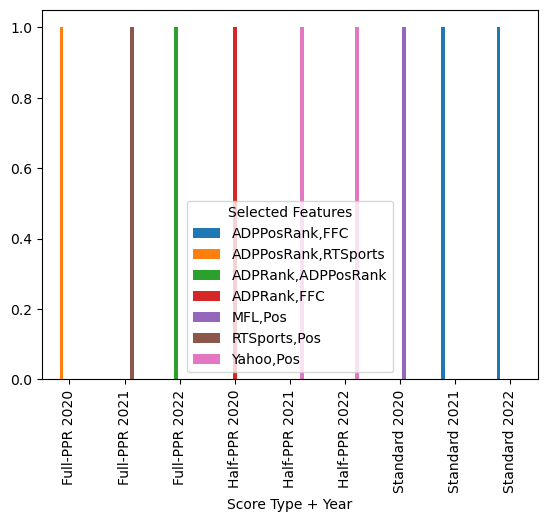

In [342]:
# Bar plot
pd.crosstab(results['Score Type + Year'], results['Selected Features']).plot.bar()